In [1]:
%load_ext ipybind
%matplotlib inline

import warnings
warnings.filterwarnings('default')

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rc('figure', figsize=(8, 8))

# xtensor

xtensor (http://xtensor.readthedocs.io/) is an array library in C++.  It defines the multi-dimensional array data structure suitable for compile-time optimization.  The array library helps us organize code and achieve fast runtime.

1. Python is slow but easy to write
2. Speed up by using numpy (still in Python)
3. Xtensor: write iterative code in C++ speed using arrays
4. Effect of house-keeping code

# Python is slow

Python is usually slow when it comes to number-crunching.  But as I will show, it's so convenient to code.

Here we consider a boundary value problem of the Laplace equation for temperature distribution in a $1\times1$ square area.

\begin{align}
& \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0 \quad (0<x<1; 0<y<1) \\
&\left\{\begin{array}{lll}
u(0,y) = 0, & u(1,y) = \sin(\pi y) & \rule{4ex}{0pt} (0 \le y \le 1) \\
u(x,0) = 0, & u(x,1) = 0 & \rule{4ex}{0pt} (0 \le x \le 1)
\end{array}\right.
\end{align}

To solve it numerically, we choose the finite-difference method.  The finite-difference method needs a grid to discretize the spatial domain.  The simplest spatial discretization is the homogeneous Cartesian grid.  Let's make a $51\times51$ Cartesian grid.

In [2]:
def make_grid():
    nx = 51
    x = np.linspace(0, 1, nx)
    gx, gy = np.meshgrid(x, x)
    u = np.zeros_like(gx)
    u[0,:] = 0
    u[-1,:] = 1 * np.sin(np.linspace(0,np.pi,nx))
    u[:,0] = 0
    u[:,-1] = 0
    return nx, x, u

In [3]:
def show_grid(size):
    fig, ax = plt.subplots(figsize=(size,size))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(x, minor=True)
    ax.set_yticks(x, minor=True)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(True, which='minor')

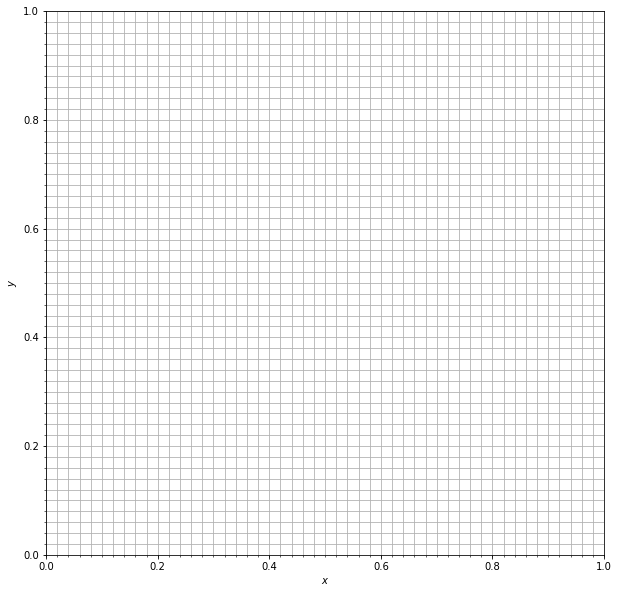

In [4]:
nx, x, uoriginal = make_grid(); show_grid(10)

After the grid is defined, we may derive the finite-differencing formula.  Use the Taylor series expansion to obtain the difference equation:

\begin{align}
%
& \frac{u(x_{i+1}, y_j) - 2u(x_i, y_j) + u(x_{i-1}, y_j)}{(\Delta x)^2} \\
&\quad + \frac{u(x_i, y_{j+1}) - 2u(x_i, y_j) + u(x_i, y_{j+1})}{(\Delta y)^2} = 0
%
\end{align}

Note $\Delta x = \Delta y$.  The difference equation is rewritten as

\begin{align}
%
u(x_i, y_j) = \frac{u(x_{i+1}, y_j) + u(x_{i-1}, y_j) + u(x_i, y_{j+1}) + u(x_i, y_{j-1})}{4}
%
\end{align}

Apply the point-Jacobi method to write a formula to iteratively solve the difference equaion:

\begin{align}
%
u^{n+1}(x_i, y_i) = \frac{u^n(x_{i+1}, y_j) + u^n(x_{i-1}, y_j) + u^n(x_i, y_{j+1}) + u^n(x_i, y_{j-1})}{4}
%
\end{align}

where $u^n$ is the solution at the $n$-th iteration.

Now we can use Python to quickly implement the solver:

In [5]:
def solve_python_loop():
    u = uoriginal.copy()
    un = u.copy()
    converged = False
    step = 0
    # Outer loop.
    while not converged:
        step += 1
        # Inner loops. One for x and the other for y.
        for it in range(1, nx-1):
            for jt in range(1, nx-1):
                un[it,jt] = (u[it+1,jt] + u[it-1,jt] + u[it,jt+1] + u[it,jt-1]) / 4
        norm = np.abs(un-u).max()
        u[...] = un[...]
        converged = True if norm < 1.e-5 else False
    return u, step, norm

In [6]:
def show_result(u, step, norm, size=7):
    print("step", step, "norm", norm)
    fig, ax = plt.subplots(figsize=(size,size))
    cs = ax.contour(x, x, u.T)
    ax.clabel(cs, inline=1, fontsize=10)

    ax.set_xticks(np.linspace(0,1,6))
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.grid(True, which='minor')

In [7]:
%%time
# Run the Python solver
u, step, norm = solve_python_loop()

CPU times: user 5.24 s, sys: 22.5 ms, total: 5.26 s
Wall time: 5.28 s


step 2097 norm 9.997406535677822e-06


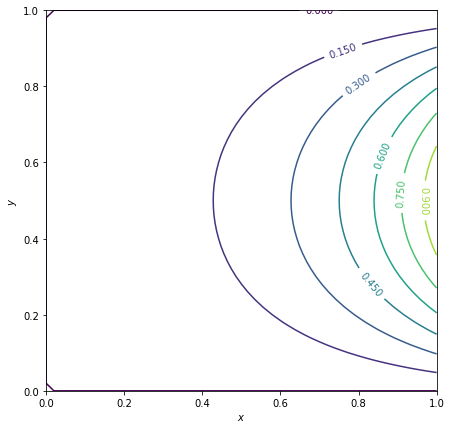

In [8]:
show_result(u, step, norm)

It takes quite a while (around 5 seconds) to converge with 2097 iterations.

Is the calculation correct?  For any numerical appliaction, correctness is the first condition.

We may compare the numerical soluation with the analytical solution.  Recall the PDE and its boundary conditions:

\begin{align}
& \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0 \quad (0<x<1; 0<y<1) \\
&\left\{\begin{array}{lll}
u(0,y) = 0, & u(1,y) = \sin(\pi y) & \rule{4ex}{0pt} (0 \le y \le 1) \\
u(x,0) = 0, & u(x,1) = 0 & \rule{4ex}{0pt} (0 \le x \le 1)
\end{array}\right.
\end{align}

Use separation of variable.  Assume the solution $u(x,y) = \phi(x)\psi(y)$.

\begin{align*}
%
& \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0 \quad \Rightarrow \quad
\phi''\psi + \phi\psi'' = 0 \\
& \Rightarrow \quad \frac{\phi''}{\phi} = -\frac{\psi''}{\psi} = \lambda
%
\end{align*}

\begin{align*}
%
\left\{\begin{array}{ll}
\phi'' - \lambda\phi = 0, & \phi(0) = 0 \\
\psi'' + \lambda\psi = 0, & \psi(0) = 0, \, \psi(1) = 0
\end{array}\right.
%
\end{align*}

$\lambda$ is the eigenvalue.  The general solution of the ODE of $\psi$ can be obtained as

\begin{align*}
%
\psi(y) = c\cos(\kappa y) + d\sin(\kappa y), \quad \kappa^2 = \lambda
%
\end{align*}

Substitude the boundary conditions to the general solution

\begin{align*}
%
& \psi(0) = c = 0 \, \Rightarrow \, c = 0 \\
& \psi(1) = d\sin(\kappa) = 0 \, \Rightarrow \, \kappa = n\pi, \, n = 1, 2, 3, \ldots \\
& \psi(y) = \sum_{n=1}^{\infty} \psi_n(y), \; \mbox{where} \; \psi_n(y) = d_n\sin(n\pi y) \\
& \Rightarrow \psi(y) = \sum_{n=1}^{\infty} d_n \sin(n\pi y)
%
\end{align*}

Substitute the eigenvalue $\lambda$ into the ODE of $\phi$

\begin{align*}
%
\phi'' - (n\pi)^2\phi = 0
%
\end{align*}

The general solution is

\begin{align*}
%
\phi_n(x) = a_n\cosh(\kappa x) + b_n\sinh(\kappa x)
%
\end{align*}

Apply the boundary condition $\phi_n(0) = a_n = 0$ and obtain $\phi_n(x) = b_n\sinh(\kappa x)$.

The solution $u(x, y)$ can now be written as

\begin{align*}
%
u(x,y) = \sum_{n=1}^{\infty}\phi_n(x)\psi_n(y) = \sum_{n=1}^{\infty} \alpha_n \sinh(n\pi x)\sin(n\pi y)
%
\end{align*}

where $\alpha_n = b_nd_n$.  Apply the last boundary condition

\begin{align*}
%
u(1,y) = \sin(\pi y) = \sum_{n=1}^{\infty}\alpha_n\sinh(n\pi)\sin(n\pi)
%
\end{align*}

It is obtained that $\alpha_1 = \sinh^{-1}(\pi)$ and $\alpha_k = 0 \forall k = 2, 3, \ldots$.  The solution of $u$ is obtained:

\begin{align*}
%
u(x, y) = \frac{\sinh(\pi x)}{\sinh(\pi)} \sin(\pi y)
%
\end{align*}

step 0 norm 0
Linf of difference is 0.004962


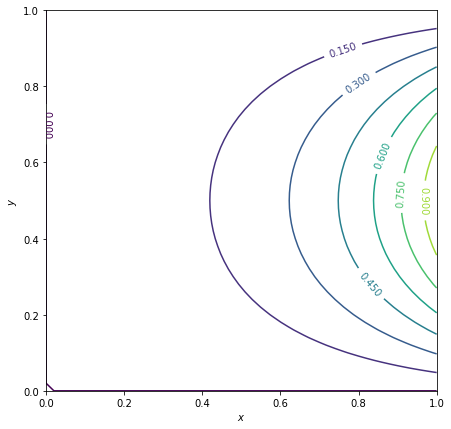

In [9]:
def solve_analytical():
    u = np.empty((len(x), len(x)), dtype='float64')
    for ix, cx in enumerate(x):
        u[ix, :] = np.sinh(np.pi*cx) / np.sinh(np.pi) * np.sin(np.pi*x)
    return u

uanalytical = solve_analytical()
show_result(uanalytical, 0, 0)
# Calculate the L inf norm.
print("Linf of difference is %f" % np.abs(u - uanalytical).max())

Say $u_a$ is the analytical solution.  $|u-u_a|_{\infty}$ is good enough.  Let's make the Python version as golden.

In [10]:
ugolden = u.copy()

# Array-based code with numpy

We usually can use numpy to speed up the slow Python loops.  Numpy implements fast calculations in C.  By using numpy, we essentially delegate the calculation to C.

In [11]:
def solve_array():
    u = uoriginal.copy()
    un = u.copy()
    converged = False
    step = 0
    while not converged:
        step += 1
        un[1:nx-1,1:nx-1] = (u[2:nx,1:nx-1] + u[0:nx-2,1:nx-1] +
                             u[1:nx-1,2:nx] + u[1:nx-1,0:nx-2]) / 4
        norm = np.abs(un-u).max()
        u[...] = un[...]
        converged = True if norm < 1.e-5 else False
    return u, step, norm

In [12]:
%%time
u, step, norm = solve_array()

CPU times: user 62.1 ms, sys: 1.6 ms, total: 63.7 ms
Wall time: 63.1 ms


The speed is much better: less than 0.1 second.  The speed up is more than 60x.

step 2097 norm 9.997406535677822e-06


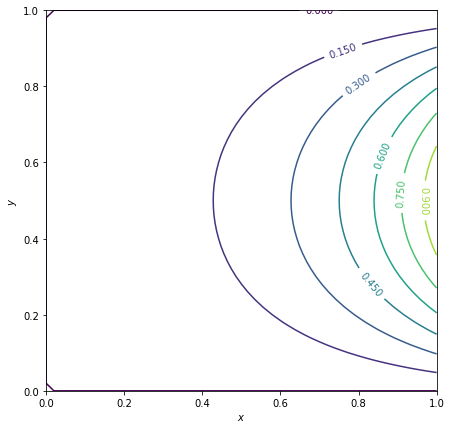

In [13]:
assert (u == ugolden).all(); show_result(u, step, norm)

# Nested loop in C++

Oftentimes numpy is still not fast enough.  Besides, it's not really easy to read.  Nested loop reads more straight-forward for our point-Jacobi method.  Now xtensor comes to help.

Except the parentheses, the C++ version looks almost the same as the Python version.

In [14]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"
#define FORCE_IMPORT_ARRAY
#include "xtensor-python/pyarray.hpp"

#include <vector>
#include <algorithm>
#include <tuple>
#include <iostream>

#include "xtensor/xarray.hpp"
#include "xtensor/xadapt.hpp"
#include "xtensor/xview.hpp"

std::tuple<xt::xarray<double>, size_t, double>
solve1(xt::xarray<double> u)
{
    const size_t nx = u.shape(0);
    xt::xarray<double> un = u;
    bool converged = false;
    size_t step = 0;
    double norm;
    while (!converged)
    {
        ++step;
        for (size_t it=1; it<nx-1; ++it)
        {
            for (size_t jt=1; jt<nx-1; ++jt)
            {
                un(it,jt) = (u(it+1,jt) + u(it-1,jt) + u(it,jt+1) + u(it,jt-1)) / 4;
            }
        }
        norm = xt::amax(xt::abs(un-u))();
        if (norm < 1.e-5) { converged = true; }
        u = un;
    }
    return std::make_tuple(u, step, norm);
}

PYBIND11_MODULE(code1, m)
{
    xt::import_numpy();
    m.def
    (
        "solve_cpp", [](xt::pyarray<double> & uin) { return solve1(xt::xarray<double>(uin)); }
    );
}

In [15]:
%%time
u, step, norm = solve_cpp(uoriginal)

CPU times: user 29.7 ms, sys: 506 µs, total: 30.2 ms
Wall time: 29.9 ms


step 2097 norm 9.997406535677822e-06


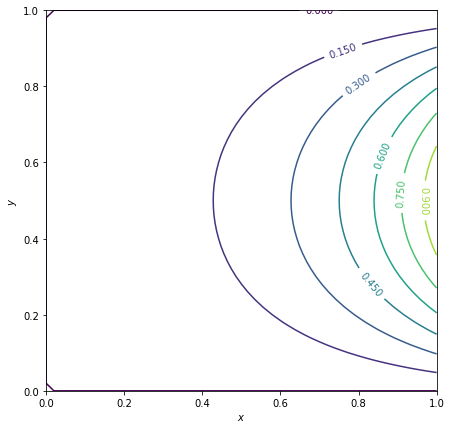

In [16]:
assert (u == ugolden).all(); show_result(u, step, norm)

# Major source of overhead: data preparation

Numerical calculation takes time.  Intuitively, developers spend time on optimizing the number-crunching code.  However, for a useful application, the house-keeping code for preparing the calculation data and post-processing the results is equally important.

In our previous example of solving the Laplace equation, all the conditions are hard-coded.  It's OK for the teaching purpose, but not useful to those who don't know so much about the math and numerical.  This time, I will use an example of curve fitting to show how the house-keeping code affects performance, and xtensor comes to help.

We will do polynomial curve fitting for data in groups of variable length.

In [17]:
%%time
# np.unique returns a sorted array.
xdata = np.unique(np.random.sample(1000000) * 1000)
ydata = np.random.sample(len(xdata)) * 1000

CPU times: user 104 ms, sys: 9.91 ms, total: 114 ms
Wall time: 117 ms


The data are prepared.  Now, the code to fit the curve is totally in C++.

In [18]:
%%pybind11 -c="-O3"

#include "pybind11/pybind11.h"
#define FORCE_IMPORT_ARRAY
#include "xtensor-python/pyarray.hpp"

#include <vector>
#include <algorithm>

#include "xtensor/xarray.hpp"
#include "xtensor/xadapt.hpp"
#include "xtensor/xview.hpp"
#include "xtensor-blas/xlinalg.hpp"

using array_type = xt::xarray<double>;

template <class AT>
xt::xarray<double> fit_poly(AT & xarr, AT & yarr, size_t order)
{
    if (xarr.size() != yarr.size()) { throw std::runtime_error("xarr and yarr size mismatch"); }
    
    xt::xarray<double> matrix(std::vector<size_t>{order+1, order+1});

    for (size_t it=0; it<order+1; ++it)
    {
        for (size_t jt=0; jt<order+1; ++jt)
        {
            double & val = matrix(it, jt);
            val = 0;
            for (size_t kt=0; kt<xarr.size(); ++kt) { val += pow(xarr[kt], it+jt); }
        }
    }

    xt::xarray<double> rhs(std::vector<size_t>{order+1});
    for (size_t jt=0; jt<order+1; ++jt)
    {
        rhs[jt] = 0;
        for (size_t kt=0; kt<yarr.size(); ++kt) { rhs[jt] += pow(xarr[kt], jt) * yarr[kt]; }
    }

    xt::xarray<double> lhs = xt::linalg::solve(matrix, rhs);
    std::reverse(lhs.begin(), lhs.end()); // to make numpy.poly1d happy.

    return lhs;
}

template <class AT>
xt::xarray<double> fit_polys(xt::xarray<double> & xarr, xt::xarray<double> & yarr, size_t order)
{
    size_t xmin = std::floor(*std::min_element(xarr.begin(), xarr.end()));
    size_t xmax = std::ceil(*std::max_element(xarr.begin(), xarr.end()));
    size_t ninterval = xmax - xmin;

    xt::xarray<double> lhs(std::vector<size_t>{ninterval, order+1});
    lhs.fill(0); // sentinel.
    size_t start=0;
    for (size_t it=0; it<xmax; ++it)
    {
        size_t stop;
        for (stop=start; stop<xarr.size(); ++stop) { if (xarr[stop]>=it+1) { break; } }

        AT sub_x = xt::view(xarr, xt::range(start, stop));
        AT sub_y = xt::view(yarr, xt::range(start, stop));        

        xt::xarray<double> sub_lhs = fit_poly(sub_x, sub_y, order);
        xt::view(lhs, it, xt::all()) = sub_lhs;
        
        start = stop;
    }

    return lhs;
}

PYBIND11_MODULE(example, m)
{
    xt::import_numpy();
    m.def
    (
        "fit_poly"
      , [](xt::pyarray<double> & xarr_in, xt::pyarray<double> & yarr_in, size_t order)
        {
            std::vector<size_t> xarr_shape(xarr_in.shape().begin(), xarr_in.shape().end());
            xt::xarray<double> xarr = xt::adapt(xarr_in.data(), xarr_shape);

            std::vector<size_t> yarr_shape(yarr_in.shape().begin(), yarr_in.shape().end());
            xt::xarray<double> yarr = xt::adapt(yarr_in.data(), yarr_shape);

            return fit_poly(xarr, yarr, order);
        }
    );
    m.def
    (
        "fit_polys"
      , [](xt::pyarray<double> & xarr_in, xt::pyarray<double> & yarr_in, size_t order)
        {
            std::vector<size_t> xarr_shape(xarr_in.shape().begin(), xarr_in.shape().end());
            xt::xarray<double> xarr = xt::adapt(xarr_in.data(), xarr_shape);
            std::vector<size_t> yarr_shape(yarr_in.shape().begin(), yarr_in.shape().end());
            xt::xarray<double> yarr = xt::adapt(yarr_in.data(), yarr_shape);
            return fit_polys<array_type>(xarr, yarr, order);
        }
    );
}

Call our `fit_poly` helper to find the fitted curve of a group of points.

[-3.78723085e+02  1.18298670e+04 -1.23089877e+05  4.27128022e+05]


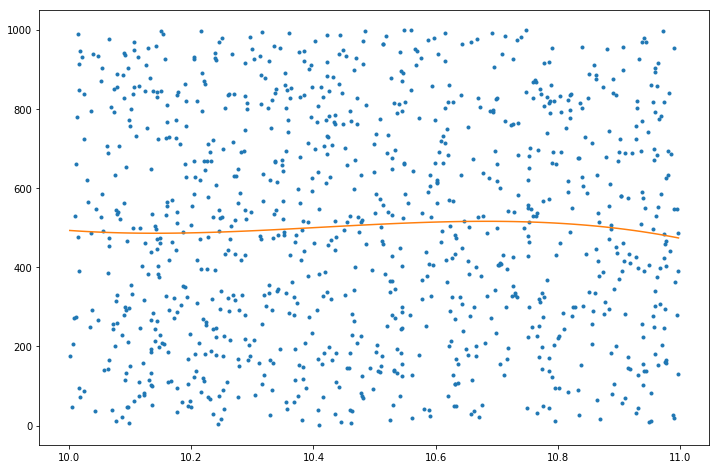

In [19]:
plt.rc('figure', figsize=(12, 8))

def plot_poly_fitted(i):
    slct = (xdata>=i)&(xdata<(i+1))
    sub_x = xdata[slct]
    sub_y = ydata[slct]
    poly = fit_poly(sub_x, sub_y, 3)
    print(poly)
    poly = np.poly1d(poly)
    xp = np.linspace(sub_x.min(), sub_x.max(), 100)
    plt.plot(sub_x, sub_y, '.', xp, poly(xp), '-')
    
plot_poly_fitted(10)

Now, let's see the impact to runtime from the house-keeping code outside the calculating helper.

In [20]:
%%time
# Do the calculation for the 1000 groups of points.
polygroup = np.empty((1000, 3), dtype='float64')
for i in range(1000):
    # Use numpy to build the point group.
    slct = (xdata>=i)&(xdata<(i+1))
    sub_x = xdata[slct]
    sub_y = ydata[slct]
    polygroup[i,:] = fit_poly(sub_x, sub_y, 2)

CPU times: user 1.42 s, sys: 6.02 ms, total: 1.42 s
Wall time: 1.43 s


In [21]:
%%time
# Using numpy to build the point groups takes a lot of time.
data_groups = []
for i in range(1000):
    slct = (xdata>=i)&(xdata<(i+1))
    data_groups.append((xdata[slct], ydata[slct]))

CPU times: user 1.28 s, sys: 14.6 ms, total: 1.3 s
Wall time: 1.3 s


In [22]:
%%time
# Fitting helper runtime is much less than building the point groups.
polygroup = np.empty((1000, 3), dtype='float64')
for it, (sub_x, sub_y) in enumerate(data_groups):
    polygroup[it,:] = fit_poly(sub_x, sub_y, 2)

CPU times: user 217 ms, sys: 5.08 ms, total: 222 ms
Wall time: 218 ms


It's very productive to write house-keeping code in Python.  As we see, the price to pay is the runtime, and oftentimes memory as well.  But to spend 5x the runtime in house-keeping code is intolerable.  We need to write C++ to speed up.

Now see the `fit_polys` C++ helper.  It detects the point group right before fitting.

In [23]:
%%time
rbatch = fit_polys(xdata, ydata, 2)

CPU times: user 215 ms, sys: 5.7 ms, total: 221 ms
Wall time: 221 ms


The runtime of the house-keeping code becomes negligible.  You may verify the calculation results too.

In [24]:
print(rbatch.shape)
# Verify batch.
assert (rbatch[i] == polygroup[i]).all()

(1000, 3)


Another interesting experiment is to throw all the points as one group to `fit_poly`.  The runtime is very close to `fit_polys`.

In [25]:
%%time
allpoly = fit_poly(xdata, ydata, 2)

CPU times: user 202 ms, sys: 1.39 ms, total: 204 ms
Wall time: 204 ms


The fitted curve is close to a straight line.

[ 1.25208296e-06 -6.97018652e-04  4.99766452e+02]


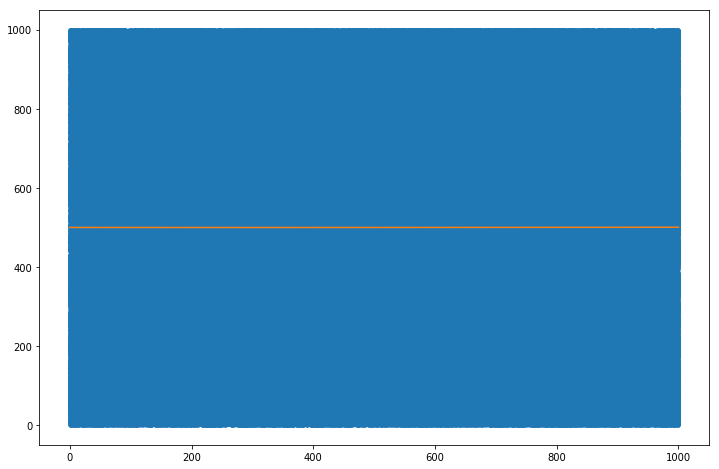

In [26]:
print(allpoly)
poly = np.poly1d(allpoly)
xp = np.linspace(xdata.min(), xdata.max(), 100)
plt.plot(xdata, ydata, '.', xp, poly(xp), '-')

References:
* xtensor; multi-dimensional arrays with broadcasting and lazy computing: https://xtensor.readthedocs.io
* xtensor-python; Python bindings for the xtensor C++ multi-dimensional array library: https://xtensor-python.readthedocs.io
* pybind11 — Seamless operability between C++11 and Python: https://pybind11.readthedocs.io/en/stable/
* IPython / Jupyter integration for pybind11: https://github.com/aldanor/ipybind

# Problems

1. xtensor allows writing array-based code in C++, just like what numpy does for Python.  Use xtensor to write array-based code in C++ by modifying the C++ version of the point-Jacobi solver.  The array-based C++ version should not have the inner loops.
2. By allowing changing the signature of the `fit_poly` function, how can we ensure the shapes of `xarr` and `yarr` to be the same, without the explicit check with `"xarr and yarr size mismatch"`?  Write code to show.